In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pytz import timezone
import math

# Unit change 

In [2]:
inch_to_mm=25.4
ft_to_meter=0.305

# Load precipitation data

In [3]:
# Add LCRA data (Flow, depth, and precipitation data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA= pd.read_excel('../data/rainfall_data/LCRA_Export/LCRA_Export_2023.xlsx')[8:]
LCRA = LCRA.set_index('Site Name')
LCRA.index.name = 'Time'
# Handle timezone
LCRA = LCRA.tz_localize('US/Central', nonexistent='shift_forward').tz_convert('UTC')
# Rename columns to be more descriptive
LCRA = LCRA.rename(columns={'W3A' : 'depth__ft', 'W3A.1' : 'flow_rate__cfs', 'W3A.3' : 'precip_tot__in'})
LCRA = LCRA.drop('W3A.2', axis=1)

# LCRA depth and discharge flow monitoring data 
lcra_depth=LCRA['depth__ft']*ft_to_meter
lcra_flow_cfs=LCRA['flow_rate__cfs']
lcra_flow=lcra_flow_cfs*ft_to_meter*ft_to_meter*ft_to_meter

#Load Forecast precipitation 
forecast = pd.read_csv('../data/rainfall_data/precip__in_forecast.csv', index_col=0)
forecast.index = pd.to_datetime(pd.Series(forecast.index))
forecast = forecast.tz_localize('UTC')

/Users/future_water_system/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [4]:
#plot precipitation graph 

def gauge_precip_data(LCRA,sample_interval_h):
    # Compute dt for each time bin
    LCRA['dt__s'] = np.roll(pd.Series(LCRA.index).diff(1).dt.seconds.values, -1)
    # Compute precipitation rate from total inches and dt
    LCRA['precip_rate__in_per_s'] = LCRA['precip_tot__in'] / LCRA['dt__s']

    # Compute inches of precipitation for desired sample interval
    precip__mm = sample_interval_h*inch_to_mm*3600 * LCRA['precip_rate__in_per_s'].resample(f'{sample_interval_h}h').mean().interpolate()
   
    return precip__mm

def forecast_precip_data(forecast, sample_interval_h):
    # Compute inches of precipitation for desired sample interval
    forecast_precip__mm = sample_interval_h*inch_to_mm*60*60 * forecast['precip_rate__in_per_s'].resample(f'{sample_interval_h}h').mean().interpolate()
    return forecast_precip__mm



# Load depth, discharge data

In [5]:
# Read and process data for 'model_gauge_depth'
model_gauge_depth = pd.read_csv('../result/base_model_result/h_j_h3_gauge.csv', index_col=[0])
model_gauge_depth.index = pd.to_datetime(model_gauge_depth.index)

# Read and process data for 'model_forecast_depth'
model_forecast_depth = pd.read_csv('../result/base_model_result/h_j_h3_forecast.csv', index_col=[0])
model_forecast_depth.index = pd.to_datetime(model_forecast_depth.index)

# Read and process data for 'model_forecast_flow'
model_forecast_flow = pd.read_csv('../result/base_model_result/Q_uk_h3_forecast.csv', index_col=[0])
model_forecast_flow.index = pd.to_datetime(model_forecast_flow.index)

# Read and process data for 'model_gauge_flow'
model_gauge_flow = pd.read_csv('../result/base_model_result/Q_uk_h3_gauge.csv', index_col=[0])
model_gauge_flow.index = pd.to_datetime(model_gauge_flow.index)

# Read and process data for 'sensor_3'
sensor_3 = pd.read_csv('../data/sensor_measurements/Sensor3_classification.csv', index_col=[0], converters={'0': pd.to_datetime})['Sensor3']
sensor_3.index = pd.to_datetime(sensor_3.index)

/var/folders/0z/96nhv68546j11lkz0bh80tqw0000gp/T/ipykernel_69219/3153395282.py:10: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  precip__mm = sample_interval_h*inch_to_mm*3600 * LCRA['precip_rate__in_per_s'].resample(f'{sample_interval_h}h').mean().interpolate()


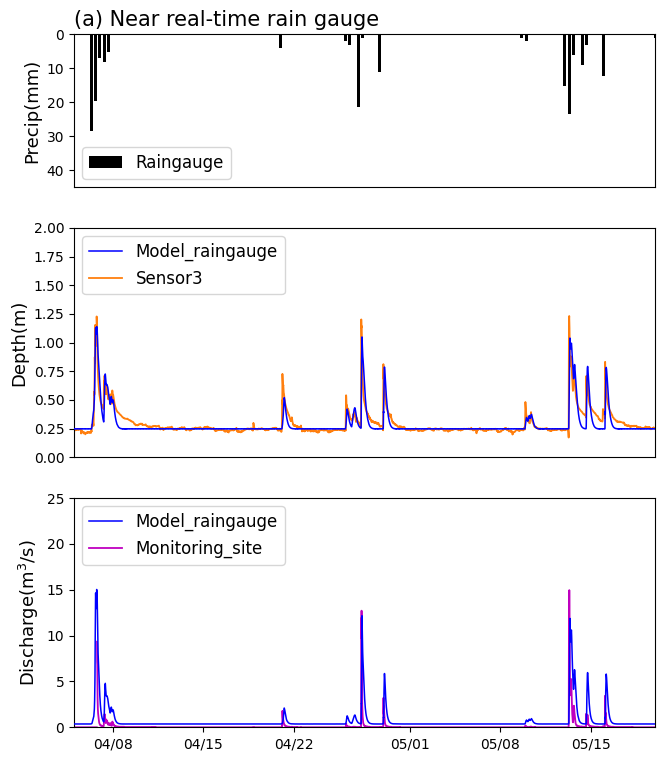

In [6]:
# Define start and end dates
start_date = datetime(2023, 4, 5, 0, 0, 0)
end_date = datetime(2023, 5, 20, 0, 0, 0)

# Create subplots
fig, ax = plt.subplots(3, figsize=(7.5, 9), gridspec_kw={'height_ratios': [2, 3, 3]})

# Plot precipitation data
sample_interval_h=8
precip__mm = gauge_precip_data(LCRA,sample_interval_h)
ax[0].bar(precip__mm.index, precip__mm, width=0.22, color='k', label='Raingauge')
ax[0].legend(fontsize=12, loc='lower left')
ax[0].set_ylabel('Precip(mm)', fontsize=13)
ax[0].set_ylim(0, 45)
ax[0].invert_yaxis()
ax[0].get_xaxis().set_visible(False)
ax[0].set_title('(a) Near real-time rain gauge', fontsize=15, loc='left')

# Plot depth data
ax[1].set_ylim(0, 2)
ax[1].plot(model_gauge_depth, label='Model_raingauge', color='blue',zorder=3,  linewidth=1.1)
ax[1].plot(sensor_3,  label='Sensor3', color='tab:orange',linewidth=1.3)
ax[1].set_ylabel('Depth(m)', fontsize=13)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].get_xaxis().set_visible(False)

# Plot discharge data
ax[2].set_ylim(0, 25)
ax[2].plot(model_gauge_flow['R_WLR17'], label='Model_raingauge', color='blue',zorder=3,  linewidth=1.1)
ax[2].plot(lcra_flow,  label='Monitoring_site', color='m',linewidth=1.3)
ax[2].set_ylabel('Discharge(m$^{3}$/s)', fontsize=13)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].legend(fontsize=12, loc='upper left')

# Set the x-axis limits for all subplots
ax[0].set_xlim(start_date, end_date)
ax[1].set_xlim(start_date, end_date)
ax[2].set_xlim(start_date, end_date)


plt.show()

(19452.0, 19497.0)

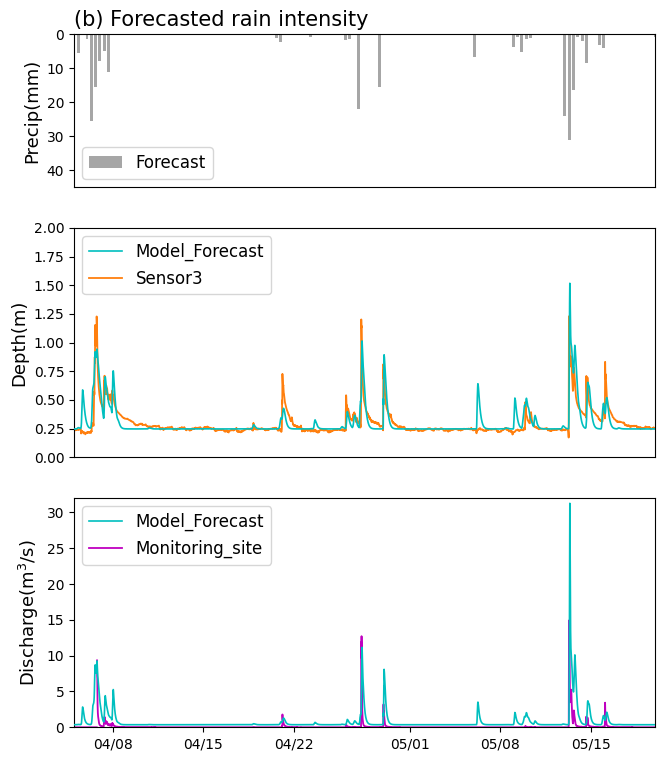

In [9]:

import matplotlib.dates as mdates
from datetime import datetime, timezone# Define start and end dates
start_date = datetime(2023, 4, 5, 0, 0, 0, tzinfo=timezone.utc)
end_date = datetime(2023, 5, 20, 0, 0, 0, tzinfo=timezone.utc)


# Create subplots
fig, ax = plt.subplots(3,figsize=(7.5, 9),gridspec_kw={'height_ratios': [2,3, 3]})
sample_interval_h=8
forecast_precip__mm=forecast_precip_data(forecast,sample_interval_h)
ax[0].bar(forecast_precip__mm.index,forecast_precip__mm,width=0.22,color='gray', alpha=0.7,label='Forecast')
ax[0].legend(fontsize=12, loc='lower left')
ax[0].set_ylabel('Precip(mm)',fontsize=13)
ax[0].set_ylim(0, 45)
ax[0].invert_yaxis()
ax[0].get_xaxis().set_visible(False)
ax[0].set_title('(b) Forecasted rain intensity', fontsize=15, loc='left')
# Plot depth data
ax[1].set_ylim(0, 2)
ax[1].get_xaxis().set_visible(False)
ax[1].plot(model_forecast_depth, label='Model_Forecast',color='c',zorder=3,  linewidth=1.2)
ax[1].plot(sensor_3, label='Sensor3', color='tab:orange',linewidth=1.3)
ax[1].set_ylabel('Depth(m)',fontsize=13)
ax[1].legend(fontsize=12, loc='upper left')

# Plot discharge data
link3=model_forecast_flow['R_WLR17']
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].set_ylim(0, 32)
ax[2].plot(link3[start_date:end_date], label='Model_Forecast',color='c',zorder=3,  linewidth=1.2)
ax[2].plot(lcra_flow,label='Monitoring_site', color='m',linewidth=1.3)
ax[2].set_ylabel('Discharge(m$^{3}$/s)',fontsize=13)
ax[2].legend(fontsize=12, loc='upper left')

# Set the x-axis limits for all subplots
ax[0].set_xlim(start_date, end_date)
ax[1].set_xlim(start_date, end_date)
ax[2].set_xlim(start_date, end_date)
